# Classification Model

- Kredi skorunu düşük, orta, yüksek olarak sınıflandırmaya çalıştığımız bir çalışmadır.
- Data az olduğu için overfitting riski vardır. Bu sebeple  çok fazla değişken kullanmak yerine sade bir model tercih edilmiştir.

In [157]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from lime.lime_tabular import LimeTabularExplainer
from scipy.stats import shapiro
import shap
import joblib
from fastapi import FastAPI
from pydantic import BaseModel
SEED = 42

In [158]:
data_path = r"C:\Users\eda.emanet\Desktop\EDA\kisisel\Projeelr\Kredi Skorlama\Data\Credit Score Classification Dataset.csv"

In [159]:
#df= pd.read_csv("./Credit Score Classification Dataset.csv")
data = pd.read_csv(data_path, sep=",")
df = data.copy()
df.head()


,Age,Gender,Income,Education,Marital Status,Number of Children,Home Ownership,Credit Score
0,25,Female,50000,Bachelor's Degree,Single,0,Rented,High
1,30,Male,100000,Master's Degree,Married,2,Owned,High
2,35,Female,75000,Doctorate,Married,1,Owned,High
3,40,Male,125000,High School Diploma,Single,0,Owned,High
4,45,Female,100000,Bachelor's Degree,Married,3,Owned,High


In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 164 non-null    int64 
 1   Gender              164 non-null    object
 2   Income              164 non-null    int64 
 3   Education           164 non-null    object
 4   Marital Status      164 non-null    object
 5   Number of Children  164 non-null    int64 
 6   Home Ownership      164 non-null    object
 7   Credit Score        164 non-null    object
dtypes: int64(3), object(5)
memory usage: 10.4+ KB


In [161]:
df.describe()

,Age,Income,Number of Children
count,164.000000,164.000000,164.000000
mean,37.975610,83765.243902,0.652439
std,8.477289,32457.306728,0.883346
min,25.000000,25000.000000,0.000000
25%,30.750000,57500.000000,0.000000
50%,37.000000,83750.000000,0.000000
75%,45.000000,105000.000000,1.000000
max,53.000000,162500.000000,3.000000


In [162]:
cat_columns = ["Gender", "Education", "Marital Status",  "Home Ownership", "Credit Score"]
for i in cat_columns:
    print( df[i].value_counts())

Gender
Female    86
Male      78
Name: count, dtype: int64
Education
Bachelor's Degree      42
Master's Degree        36
Doctorate              31
High School Diploma    30
Associate's Degree     25
Name: count, dtype: int64
Marital Status
Married    87
Single     77
Name: count, dtype: int64
Home Ownership
Owned     111
Rented     53
Name: count, dtype: int64
Credit Score
High       113
Average     36
Low         15
Name: count, dtype: int64


In [163]:
int_cat =["Age", "Income","Number of Children" ]
normality_results = []
numeric_cols = df[int_cat].columns

for col in numeric_cols:
    stat, p_value = shapiro(df[col].dropna())  # NaN'leri at
    result = {
        'Feature': col,
        'Shapiro-Wilk Statistic': stat,
        'p-value': p_value,
        'Normal Dağılım': 'Evet' if p_value > 0.05 else 'Hayır'
    }
    normality_results.append(result)

normality_df = pd.DataFrame(normality_results)
print(normality_df)


              Feature  Shapiro-Wilk Statistic       p-value Normal Dağılım
0                 Age                0.946891  7.707251e-06          Hayır
1              Income                0.979809  1.700199e-02          Hayır
2  Number of Children                0.722096  2.935348e-16          Hayır


- 162 adet gözlem olduğu için Shapiro-wilk testi seçilmiştir. Değişkenler normal dağılmamıştır 

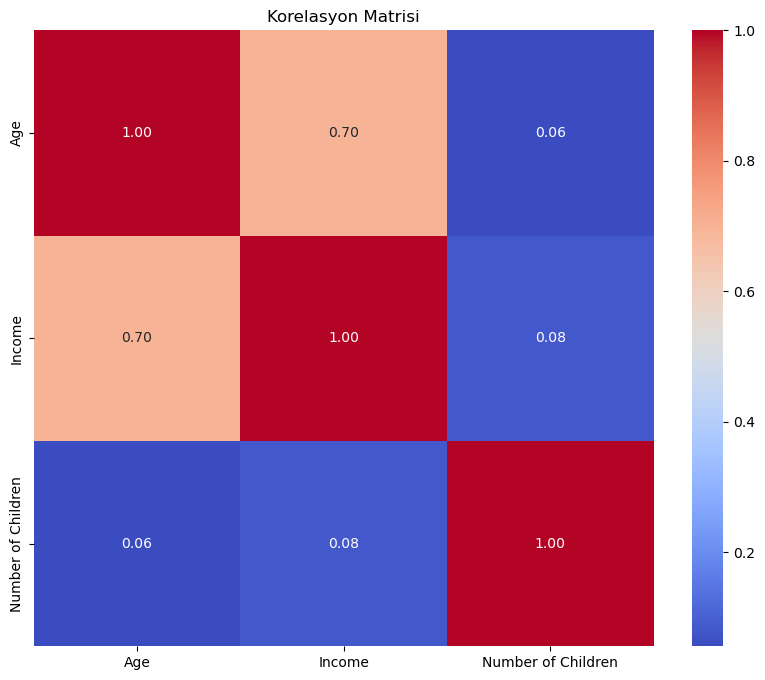

In [164]:

correlation_matrix = df[int_cat].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korelasyon Matrisi")
plt.show()

- Age ve Income arasında korelasyon vardır.

In [165]:
df["Education"] = df["Education"].str.replace("Bachelor's Degree", "Bachelors_Degree")
df["Education"] = df["Education"].str.replace("Master's Degree", "Masters_Degree")
df["Education"] = df["Education"].str.replace("Associate's Degree", "Associates_Degree")


In [166]:
data["Credit Score"].value_counts()

Credit Score
High       113
Average     36
Low         15
Name: count, dtype: int64

In [167]:
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd

ordinal_map = {"Low": 0, "Average": 1, "High": 2}

df["Credit_Score_Encoded"] = df["Credit Score"].map(ordinal_map)

one_hot_cols = ["Gender", "Marital Status", "Home Ownership"] # home ownership i de ordinAL DENE
df_encoded = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

education_order = ['High School Diploma',"Associates_Degree" , 'Bachelors_Degree', 'Masters_Degree', 'Doctorate']
ordinal_encoder = OrdinalEncoder(categories=[education_order])
df_encoded["Education_encoded"] = ordinal_encoder.fit_transform(df[["Education"]])

df_encoded.drop("Education", axis=1, inplace=True)




In [168]:
x= df_encoded[['Age','Income', 'Number of Children','Gender_Male', 'Marital Status_Single', 'Home Ownership_Rented', 'Education_encoded' ]]
y= df_encoded[['Credit_Score_Encoded']]

In [169]:
x.columns = x.columns.str.replace(" ", "_")
x


,Age,Income,Number_of_Children,Gender_Male,Marital_Status_Single,Home_Ownership_Rented,Education_encoded
0,25,50000,0,False,True,True,2.0
1,30,100000,2,True,False,False,3.0
2,35,75000,1,False,False,False,4.0
3,40,125000,0,True,True,False,0.0
4,45,100000,3,False,False,False,2.0
...,...,...,...,...,...,...,...
159,29,27500,0,False,True,True,0.0
160,34,47500,0,True,True,True,1.0
161,39,62500,2,False,False,False,2.0
162,44,87500,0,True,True,False,3.0


In [170]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED, stratify=y, 
    shuffle=True )

In [171]:
# Random Forest 
rf = RandomForestClassifier()
st = StandardScaler()
st.fit(x_train)
model = rf.fit(x_train, y_train)
pred = model.predict(x_test)
accuracy_score(y_test, pred)
print(classification_report(y_test, pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.86      0.86      0.86         7
           2       0.96      0.96      0.96        23

    accuracy                           0.94        33
   macro avg       0.94      0.94      0.94        33
weighted avg       0.94      0.94      0.94        33



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [172]:
# Dengesiz sınıf problemini çözmek için 
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

from collections import Counter
print("SMOTE sonrası sınıf dağılımı:", Counter(y_train_smote))

SMOTE sonrası sınıf dağılımı: Counter({'Credit_Score_Encoded': 1})


## Random Forest

In [173]:
# Random Forest 
rf = RandomForestClassifier()
st = StandardScaler()
st.fit(x_train)
model_sm = rf.fit(x_train_smote, y_train_smote)
pred = model_sm.predict(x_test)
accuracy_score(y_test, pred)
print(classification_report(y_test, pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.86      0.86      0.86         7
           2       0.96      0.96      0.96        23

    accuracy                           0.94        33
   macro avg       0.94      0.94      0.94        33
weighted avg       0.94      0.94      0.94        33



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


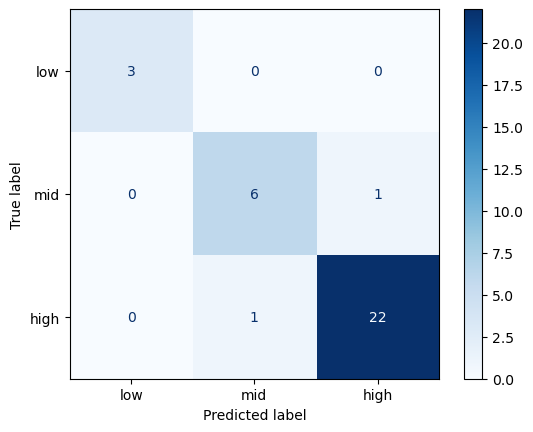

In [174]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["low", "mid", "high"])
disp.plot(cmap='Blues')

## XGBoost 



In [175]:
xgb = XGBClassifier()
st.fit(x_train)
model_xgb = xgb.fit(x_train, y_train)
pred_xg = model_xgb.predict(x_test)
print(classification_report(y_test, pred_xg))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      0.86      0.92         7
           2       0.96      1.00      0.98        23

    accuracy                           0.97        33
   macro avg       0.99      0.95      0.97        33
weighted avg       0.97      0.97      0.97        33



In [176]:
# Overfitting'i inceleme

train_preds = model_xgb.predict(x_train)
train_acc = accuracy_score(y_train, train_preds)

# Test verisindeki performans
test_preds = model_xgb.predict(x_test)
test_acc = accuracy_score(y_test, test_preds)

print(f"Train Accuracy: {train_acc:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")


Train Accuracy: 1.00
Test Accuracy: 0.97


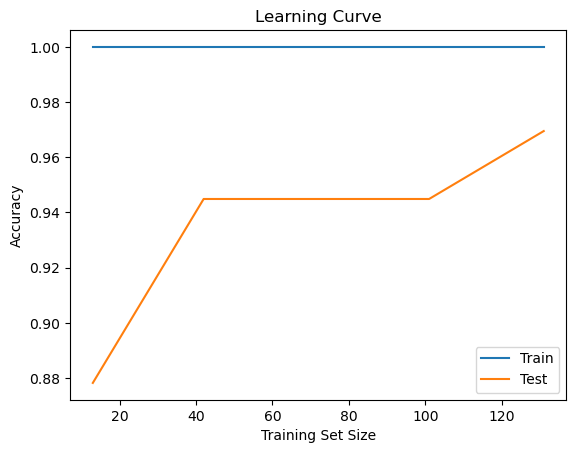

In [177]:
train_sizes, train_scores, test_scores = learning_curve(
    model_xgb, x, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label="Train")
plt.plot(train_sizes, test_mean, label="Test")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Learning Curve")
plt.show()


- Grafiği incelediğimizde overfitting var gibi gözüküyor

In [178]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model_xgb, x, y, cv=5, scoring='accuracy')
print("Cross val accuracy ort:", scores.mean())

Cross val accuracy ort: 0.9695075757575757


Bu durumda hafif bir overfitting var, ama kritik düzeyde değil. Çünkü:

 - Test doğruluğun oldukça yüksek.

 - Cross-validation sonucu da çok iyi.

 - Veri muhtemelen küçük olduğu için Train doğruluğu %100’e vuruyor ama bu, küçük veri setlerinde doğal olabilir.



# Hiperparametre Ayarları

In [179]:
param_grid = {
    'max_depth': [3, 4, 5],             # Ağaç derinliği → Daha düşük derinlik = daha az overfit
    'learning_rate': [0.01, 0.1, 0.2],  # Öğrenme oranı → Küçük oranlar daha sağlam öğrenme sağlar
    'n_estimators': [50, 100, 150],     # Ağaç sayısı
    'subsample': [0.7, 0.8, 1.0],       # Verinin ne kadarı her ağaçta kullanılacak
    'colsample_bytree': [0.7, 0.8, 1.0],# Özelliklerin ne kadarı her ağaçta kullanılacak
    'gamma': [0, 1],                    # Dallanma için minimum kayıp azaltımı
    'reg_alpha': [0, 0.1],              # L1 cezası (sparsity sağlar)
    'reg_lambda': [1, 1.5]              # L2 cezası (ağaç karmaşıklığını azaltır)
}

In [180]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1_weighted',  # Çok sınıflı problemde iyi bir metrik
    cv=5,
    verbose=1,
    n_jobs=-1               # Tüm işlemcileri kullanarak paralel çalıştır
)

grid_search.fit(x_train, y_train)


Fitting 5 folds for each of 1944 candidates, totalling 9720 fits


c:\ProgramData\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 1.0], 'gamma': [0, 1],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'n_estimators': [50, 100, 150],
                         'reg_alpha': [0, 0.1], 'reg_lambda': [1, 1.5],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='f1_weighted', verbose=1)

In [181]:
print("En iyi parametreler:", grid_search.best_params_)
print("En iyi skor:", grid_search.best_score_)


En iyi parametreler: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.7}
En iyi skor: 0.9611606267476713


In [182]:
best_model = grid_search.best_estimator_
pred_xg_best = best_model.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_xg_best))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      0.86      0.92         7
           2       0.96      1.00      0.98        23

    accuracy                           0.97        33
   macro avg       0.99      0.95      0.97        33
weighted avg       0.97      0.97      0.97        33



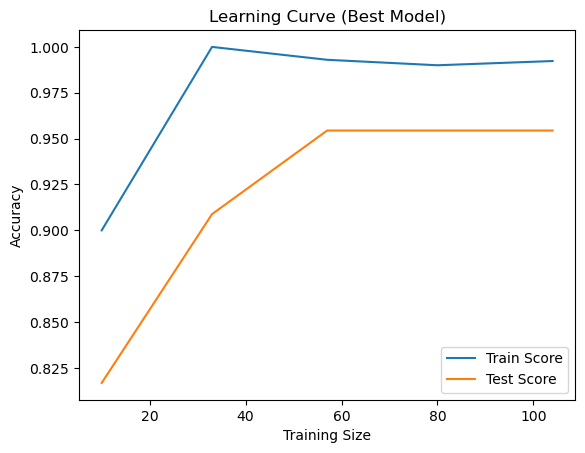

In [183]:
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X=x_train, y=y_train,
    cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label='Train Score')
plt.plot(train_sizes, test_mean, label='Test Score')
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve (Best Model)")
plt.legend()
plt.show()


In [184]:
# Tahminler
train_preds = best_model.predict(x_train)
test_preds = best_model.predict(x_test)

# Skorlar
train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Fark (Train - Test): {train_acc - test_acc:.4f}")


Train Accuracy: 0.9924
Test Accuracy:  0.9697
Fark (Train - Test): 0.0227


Fark (Train - Test)	Yorum;
- 0.00 - 0.02	✅ Model çok dengeli
- 0.02 - 0.05	⚠️ Hafif overfitting
- >0.05	 🚨 Dikkat! Overfitting yüksek

- Fark 0.0227 olduğundan hafif bir overfitting vardır

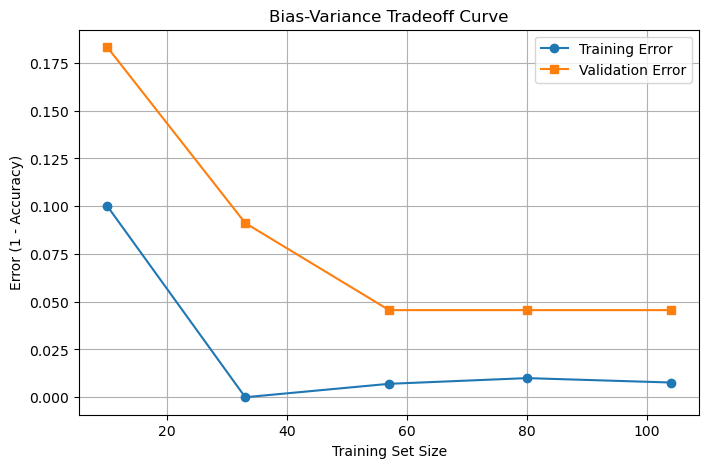

In [185]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,        
    X=x_train,
    y=y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

train_error = 1 - train_scores.mean(axis=1)
test_error = 1 - test_scores.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_error, label="Training Error", marker='o')
plt.plot(train_sizes, test_error, label="Validation Error", marker='s')
plt.title("Bias-Variance Tradeoff Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Error (1 - Accuracy)")

plt.legend()
plt.grid(True)
plt.show()


Gözlem	Açıklama:
- 🎯 Train error ≈ 0	Model eğitim verisini çok iyi öğreniyor (low bias)
- 🔁 Test error ≈ sabit ve düşük	Modelin genellemesi güçlü (low variance)
- 🟠 Aradaki fark küçük ve stabil	Overfitting yok, model dengede
- 🔵 Bu durumda:

- High bias yok (çünkü train error çok düşük)

- High variance da yok (test error sabit ve düşük)

- Bu grafik bize başarılı ve dengeli bir model olduğunu gösteriyor.👏

# LIME ve SHAP 

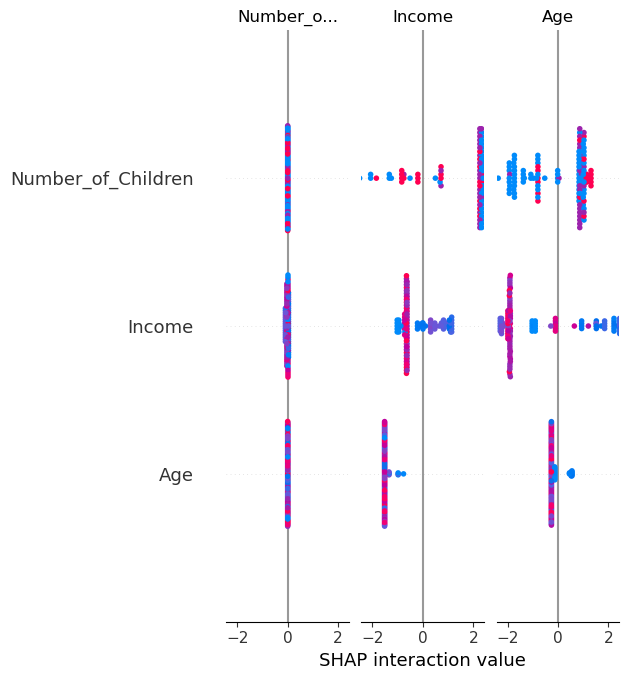

In [186]:
explainer = shap.TreeExplainer(best_model)

shap_values = explainer.shap_values(x_train)

shap.summary_plot(shap_values, x_train)


Model için en önemli değişkenler;
- Number of Children,
- Income,
- Age

In [187]:

explainer = LimeTabularExplainer(training_data=x_train.values,
                                 feature_names=x_train.columns,
                                 class_names=['Low', 'Average', 'High'], #  best_model.classes_  buradaki değerlerin etikettidir.
                                 mode='classification')

exp = explainer.explain_instance(x_test.iloc[20].values,  ## buradan herhnagi bir örnek seçebilirsin!!!
                                 best_model.predict_proba,
                                 num_features=5)

exp.show_in_notebook()

- Burada Age değişkenin genç olması, income yüksek olması High sınıfına gitmesine sebep olmuştur.

In [188]:
joblib.dump(best_model, "xgb_model.pkl")

['xgb_model.pkl']

In [189]:
### pip freeze > requirements.txt
## kullanılan kütüphaneleri requirements.txt'e yazdırmak için

## FastAPI

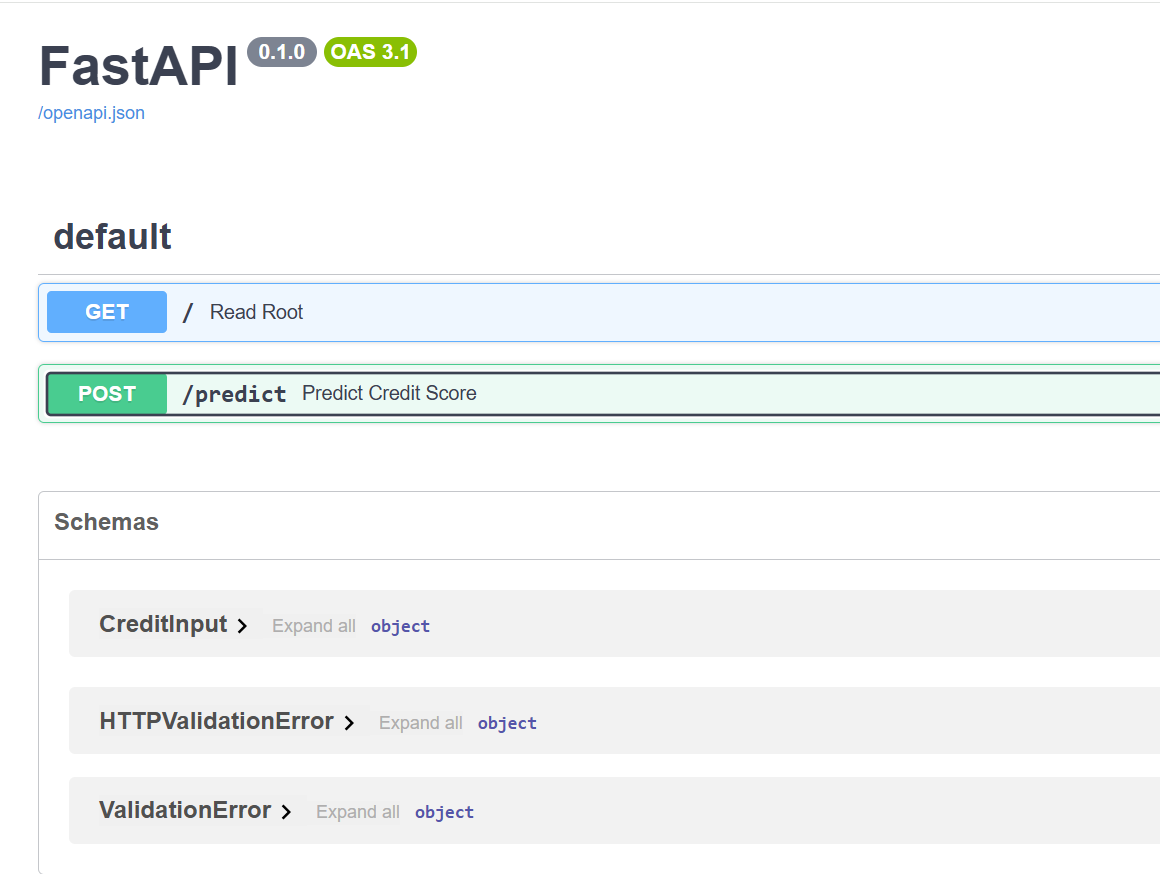

## Deneme Yapma

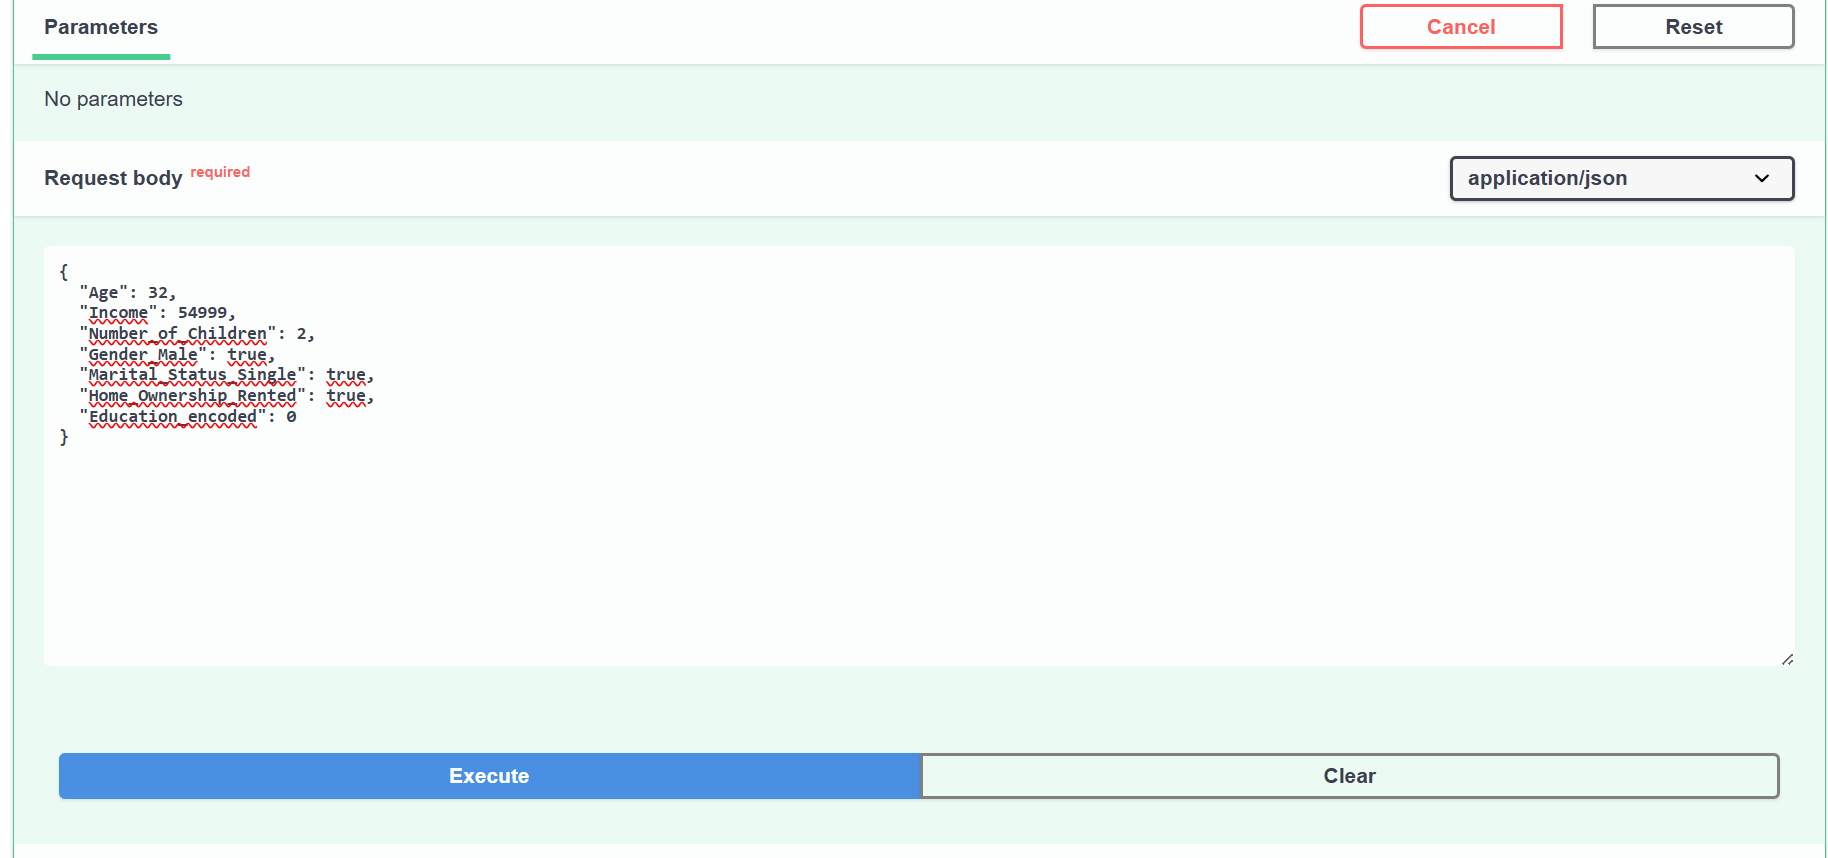

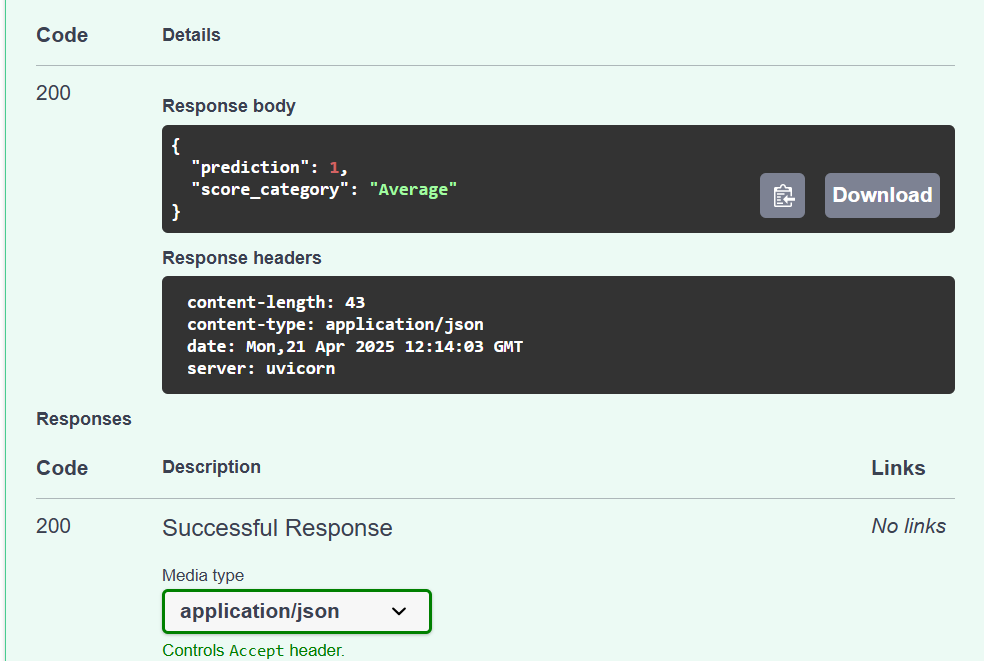

# Yol Haritası

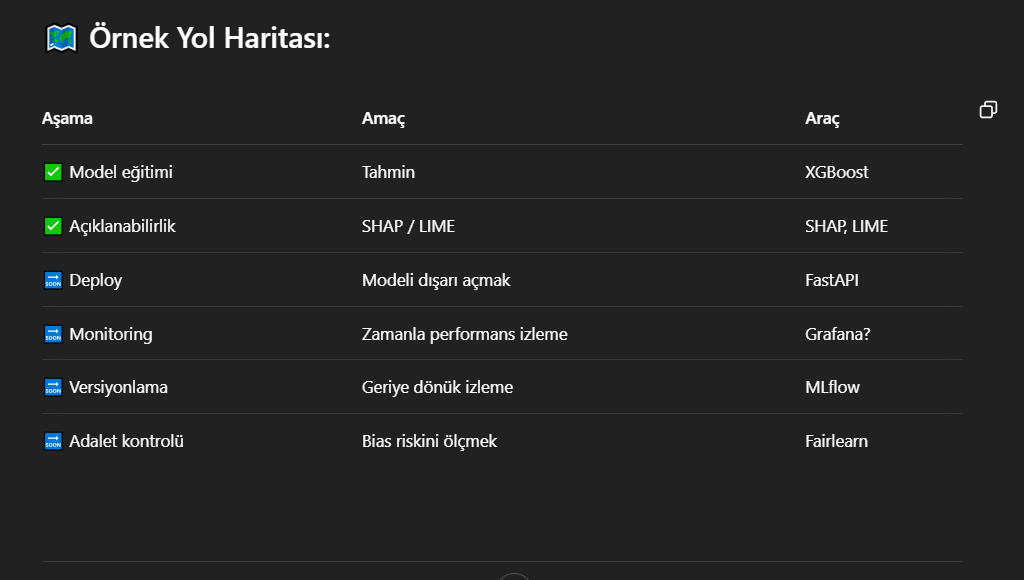